# Pips and Connection 

In [1]:
%pip install mongoengine
%pip install pycoshark
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
import matplotlib.pyplot as plt
from mongoengine import connect
from pycoshark.mongomodels import Project, VCSSystem, Commit, FileAction, Hunk, Refactoring, IssueSystem, Issue, IssueComment, MailingList, Message
from pycoshark.utils import create_mongodb_uri_string
from mongoengine.connection import disconnect

# You may have to update this dict to match your DB credentials
credentials = {'db_user': '',
               'db_password': '',
               'db_hostname': 'localhost',
               'db_port': 27017,
               'db_authentication_database': '',
               'db_ssl_enabled': False}

uri = create_mongodb_uri_string(**credentials)

# disconnect(alias='default')
connect('smartshark_2_2', host=uri, alias='default')

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

In [4]:
projectsList = ['archiva', 'commons-math', 'ant-ivy', 'kafka','zeppelin','mahout','struts','wss4j','xerces2-j','jspwiki']

smallInfos = {}
fullInfos = {}
infoCommit = {}
pr = Project.objects().all()

prt =[]

for p1 in pr:
    if(p1.name is not  prt ):
        prt.append(p1.name)

issue_type = {}
for p in prt:
    project = Project.objects(name=p).get()

    if(project is not None):
        

        vcs_system = VCSSystem.objects(project_id=project.id).get()

        num_commits = Commit.objects(vcs_system_id=vcs_system.id).count()

        try: 

            issue_tracker = IssueSystem.objects(project_id=project.id).get()

            

            for issue in Issue.objects(issue_system_id=issue_tracker.id):
                if issue.issue_type_verified is not None:
                    if(issue.issue_type_verified not in issue_type):
                        issue_type[issue.issue_type_verified] = 1
                    else:
                        issue_type[issue.issue_type_verified] += 1
                    
        except:
            print("No issue tracker for project " + p)
                      
print(issue_type)

No issue tracker for project maven
No issue tracker for project tapestry-5
No issue tracker for project james
{'documentation': 785, 'bug': 8155, 'other': 1228, 'improvement': 4384, 'test': 512, 'feature_request': 549, 'refactoring': 92}


# Analise

In [3]:
projectsList = ['archiva', 'commons-math', 'ant-ivy', 'kafka','zeppelin','mahout','struts','wss4j','xerces2-j','jspwiki']
smallInfos = {}
fullInfos = {}
infoCommit = {}

for p in projectsList:
    project = Project.objects(name=p).get()

    vcs_system = VCSSystem.objects(project_id=project.id).get()

    print('VCS System:', vcs_system.url)

    num_commits = Commit.objects(vcs_system_id=vcs_system.id).count()

    print('Number of commits:', num_commits)

    issue_tracker = IssueSystem.objects(project_id=project.id).get()

    print('Issue Tracker:', issue_tracker.url)

    num_issues = Issue.objects(issue_system_id=issue_tracker.id).count()

    print('Number of issues:', num_issues)

    count_linked_issue = 0
    count_refactorings_refdiff = 0
    count_refactorings_refactoringminer = 0

    for issue in Issue.objects(issue_system_id=issue_tracker.id):
        if issue.issue_type_verified is not None and issue.issue_type_verified.lower()=='bug':
            for commit in Commit.objects(linked_issue_ids=issue.id):
                refdiff = Refactoring.objects(commit_id=commit.id, detection_tool='refDiff').count()
                miner = Refactoring.objects(commit_id=commit.id, detection_tool='rMiner').count()
                if(refdiff > 0 or miner > 0):
                    count_refactorings_refdiff += refdiff
                    count_refactorings_refactoringminer += miner
                    count_linked_issue += 1
                    infoCommit[p] = {commit.id : {'linked_issue_ids': commit.linked_issue_ids, 'refactorings_refdiff': Refactoring.objects(commit_id=commit.id, detection_tool='refDiff').count(), 'refactorings_refactoringminer': Refactoring.objects(commit_id=commit.id, detection_tool='rMiner').count()}}
    
  
    print('count_linked_issue:', count_linked_issue)
    print('Number of refactorings detected by refDiff:', count_refactorings_refdiff)
    print('Number of refactorings detected by RefactoringMiner:', count_refactorings_refactoringminer)
    fullInfos[p] = {'num_commits': num_commits, 'num_issues': num_issues, 'total_linked_issue': count_linked_issue, 'total_refactorings_refdiff': count_refactorings_refdiff, 'total_refactorings_refactoringminer': count_refactorings_refactoringminer, 'infoCommit': infoCommit}   
    smallInfos[p] = {'num_commits': num_commits, 'num_issues': num_issues, 'total_linked_issue': count_linked_issue, 'total_refactorings_refdiff': count_refactorings_refdiff, 'total_refactorings_refactoringminer': count_refactorings_refactoringminer}   

VCS System: https://github.com/apache/archiva.git
Number of commits: 10261
Issue Tracker: https://issues.apache.org/jira/rest/api/2/search?jql=project=ARCHIVA
Number of issues: 2010
count_linked_issue: 176
Number of refactorings detected by refDiff: 599
Number of refactorings detected by RefactoringMiner: 1549
VCS System: https://github.com/apache/commons-math
Number of commits: 7222
Issue Tracker: https://issues.apache.org/jira/rest/api/2/search?jql=project=MATH
Number of issues: 1455
count_linked_issue: 96
Number of refactorings detected by refDiff: 168
Number of refactorings detected by RefactoringMiner: 341
VCS System: https://github.com/apache/ant-ivy
Number of commits: 3189
Issue Tracker: https://issues.apache.org/jira/rest/api/2/search?jql=project=IVY
Number of issues: 1585
count_linked_issue: 151
Number of refactorings detected by refDiff: 372
Number of refactorings detected by RefactoringMiner: 508
VCS System: https://github.com/apache/kafka.git
Number of commits: 6971
Issue T

In [4]:
xNumCommits = []
yLinkedIssue = []
zNumIssues = []
for info in smallInfos:
    xNumCommits.append(smallInfos[info]['num_commits'])
    yLinkedIssue.append(smallInfos[info]['total_linked_issue'])
    zNumIssues.append(smallInfos[info]['num_issues'])

In [5]:
zNumIssues

[2010, 1455, 1585, 7007, 3557, 2062, 4931, 659, 1696, 980]

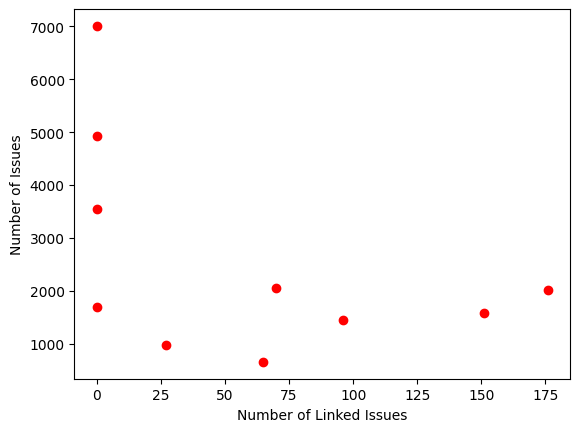

In [6]:

import matplotlib.pyplot as plt

plt.plot( yLinkedIssue,zNumIssues, 'ro')
plt.ylabel('Number of Issues')
plt.xlabel('Number of Linked Issues')
plt.show()

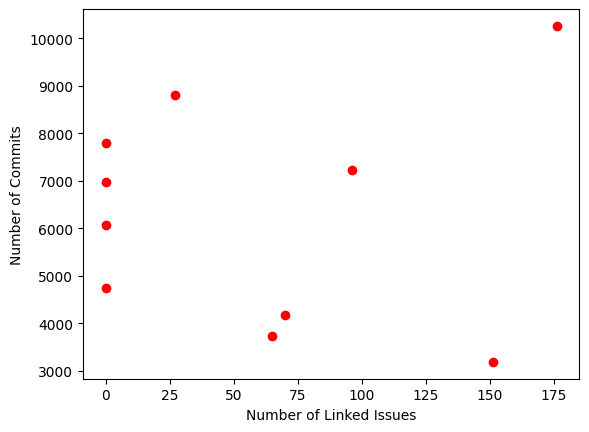

In [7]:
plt.plot( yLinkedIssue, xNumCommits,'ro')
plt.ylabel('Number of Commits')
plt.xlabel('Number of Linked Issues')
plt.show()